In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
import pandas as pd
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
df = pd.read_csv('two_step_data.txt')

In [3]:
print(df)

                               subject  trial  drift_1  drift_2  drift_3  \
0       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      1    0.743    0.273    0.717   
1       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      2    0.714    0.290    0.712   
2       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      3    0.709    0.346    0.714   
3       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      4    0.732    0.339    0.704   
4       3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO      5    0.717    0.408    0.722   
...                                ...    ...      ...      ...      ...   
341994  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    196    0.384    0.712    0.479   
341995  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    197    0.373    0.734    0.460   
341996  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    198    0.440    0.748    0.461   
341997  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    199    0.471    0.737    0.468   
341998  3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    200    0.487    0.736    0.447   

        drift_4  stage_1_choice  stage_1_rt  transition  stage_2_choice  \
0         0.

In [4]:
from tqdm import tqdm
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

In [5]:
gb = df.groupby('subject').stage_1_choice.apply(lambda x: x.notnull().mean())

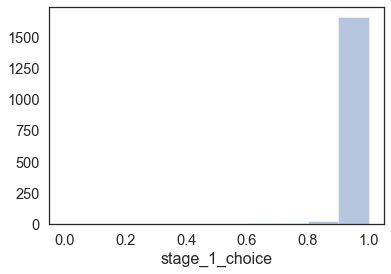

In [6]:
sns.distplot(gb, kde=False, bins=np.linspace(0,1,11))

# Data Cleaning & Organization

Reinforcement-Learning Task Exclusion Criteria: Subjects were excluded if they missed more than 10% of trials (Exp1: n=11; Exp2: n=62), responded on the same key on more than 95% of trials on which they registered a response (Exp1: n=46; Exp2: n=85) or had implausibly fast reaction times, i.e. ± 2 standard deviations from the mean (Exp1: n=9; Exp2: n=18).

In [7]:
df.groupby('subject')

In [8]:
df.groupby('subject').stage_1_choice.mean()

subject
3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO    1.000000
304SM51WA34XCM4E67SL28LY2UCBS4    1.557789
308Q0PEVB8DPUFML3BKB70KL51T9IW    1.515152
308Q0PEVB8DPUFML3BKB70KL6Q8I9Z    1.560000
308XBLVESI4LB741RISGCYG2G16RBR    1.600000
                                    ...   
3ZWFC4W1UU7BOOGHWKECVO7NVXMRFT    1.479798
3ZWFC4W1UU7BOOGHWKECVO7NVZ7FR6    1.341709
3ZY8KE4ISJ308KN7JKUG8K04N69VQN    1.688442
3ZY8KE4ISJ308KN7JKUG8K04OQDQVR    1.370000
3ZY8KE4ISJ308KN7JKUG8K04OS9VQW    1.585000
Name: stage_1_choice, Length: 1710, dtype: float64

In [9]:
df_copy = df.copy()

In [10]:
gd = df_copy.groupby('subject')

In [11]:
# retain subjects with less than 20% of data missing
f = df_copy.groupby('subject').filter(lambda x: x.stage_1_choice.isnull().mean() <= 0.2)

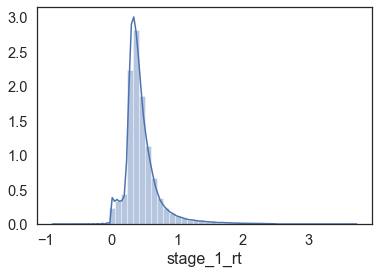

In [12]:
sns.distplot(f['stage_1_rt'])

In [13]:
f['stage_1_rt']

0           NaN
1         0.444
2         0.459
3         0.409
4         0.356
          ...  
341994    0.449
341995    0.132
341996    0.838
341997    0.406
341998    0.510
Name: stage_1_rt, Length: 336599, dtype: float64

In [14]:
f = f.groupby('subject').filter(lambda x: np.logical_and(x.stage_1_rt < 2.5, x.stage_1_rt > 0.2).mean() >= 0.8)

In [15]:
f

,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
0,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,1,0.743,0.273,0.717,0.479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,2,0.714,0.290,0.712,0.456,1.0,0.444,1.0,1.0,2.0,1.566,1.0
2,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,3,0.709,0.346,0.714,0.466,1.0,0.459,0.0,1.0,3.0,0.669,1.0
3,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,4,0.732,0.339,0.704,0.386,1.0,0.409,1.0,1.0,2.0,0.491,1.0
4,3018Q3ZVOIQGSXZ9L4SKHNWWZ1CRAO,5,0.717,0.408,0.722,0.422,1.0,0.356,1.0,1.0,2.0,0.574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341994,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,196,0.384,0.712,0.479,0.387,1.0,0.449,0.0,1.0,3.0,0.507,1.0
341995,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,197,0.373,0.734,0.460,0.375,1.0,0.132,1.0,1.0,2.0,0.432,1.0
341996,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,198,0.440,0.748,0.461,0.410,1.0,0.838,0.0,1.0,3.0,0.430,1.0
341997,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,199,0.471,0.737,0.468,0.375,1.0,0.406,0.0,1.0,3.0,0.396,0.0


In [16]:
f['stage_1_choice'] = f['stage_1_choice'] - 1

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [17]:
f['stage_1_choice']

0         NaN
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
341994    0.0
341995    0.0
341996    0.0
341997    0.0
341998    1.0
Name: stage_1_choice, Length: 298999, dtype: float64

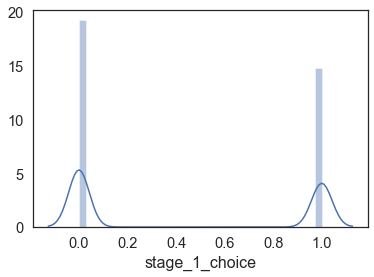

In [18]:
sns.distplot(f['stage_1_choice'])

In [19]:
f = f.groupby('subject').filter(lambda x: np.logical_and(x.stage_1_choice.mean() > 0.05, x.stage_1_choice.mean() < 0.95))


In [20]:
f.subject.nunique()

1409

In [21]:
subs = f['subject'].unique()

In [22]:
data = []
for s in subs:
    subdata = f.loc[f['subject'] == s]
    
    r = subdata['outcome']
    Y1 = subdata['stage_1_choice'] - 1
    t = subdata['transition']

    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    sub_list = np.array([s] * len(prev_R))
    
    g = DataFrame(np.column_stack([sub_list, prev_R, prev_T, stay]), columns=['subject','prev_R', 'prev_T', 'Stay'])
    data.append(g)

In [23]:
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

In [24]:
data

,subject,prev_R,prev_T,Stay
0,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
1,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
2,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
3,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
4,304SM51WA34XCM4E67SL28LY2UCBS4,0.0,0.0,0
...,...,...,...,...
194,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,0.0,0.0,1
195,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1
196,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,1.0,1
197,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1


# Model-based vs. Model-free Estimation

if prev_T rare(0)|prev_R common(1) stay prob is much less than prev_T common(1)|prev_R rare(0) then model free
if similar, then model-based

(T, R) = (0, 1) is less than (1, 0)
on average number of stays

In [25]:
data

,subject,prev_R,prev_T,Stay
0,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
1,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
2,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,1
3,304SM51WA34XCM4E67SL28LY2UCBS4,1.0,1.0,0
4,304SM51WA34XCM4E67SL28LY2UCBS4,0.0,0.0,0
...,...,...,...,...
194,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,0.0,0.0,1
195,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1
196,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,1.0,1
197,3ZY8KE4ISJ308KN7JKUG8K04OS9VQW,1.0,0.0,1


In [26]:
subjects = data['subject'].unique()

In [27]:
len(subjects)

1409

In [28]:
import math

## Method #1

In [50]:
MB = []
MF = []
for s in subjects:
    sd = data.loc[data['subject'] == s]
    
    # P(stay | rewarded (R=1), common (T=1))
    g1 = np.array(sd.loc[(sd['prev_R'] == '1.0') & (sd['prev_T'] == '1.0'), 'Stay'], dtype=int).mean()
    # P(stay | rewarded (R=1), uncommon (T=0))
    g2 = np.array(sd.loc[(sd['prev_R'] == '1.0') & (sd['prev_T'] == '0.0'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), common (T=1))
    g3 = np.array(sd.loc[(sd['prev_R'] == '0.0') & (sd['prev_T'] == '1.0'), 'Stay'], dtype=int).mean()
    # P(stay | unrewarded (R=0), uncommon (T=0))
    g4 = np.array(sd.loc[(sd['prev_R'] == '0.0') & (sd['prev_T'] == '0.0'), 'Stay'], dtype=int).mean()
    
    metric = (g1 - g2) - (g3- g4)
    if metric < 0.2: MF.append(s)
    else: MB.append(s)

In [51]:
percent_MB = len(MB)/len(subjects)
percent_MF = len(MF)/len(subjects)
print("Percent of model-based participants: " + str(round(percent_MB,2)))
print("Percent of model-free participants: " + str(round(percent_MF,2)))

Percent of model-based participants: 0.21
Percent of model-free participants: 0.79


In [54]:
dd = []
for s in MB:
    mt = f.loc[f['subject'] == s]
    
    r = mt['outcome']
    Y1 = mt['stage_1_choice']
    t = mt['transition']

    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    
    g = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    dd.append(g)

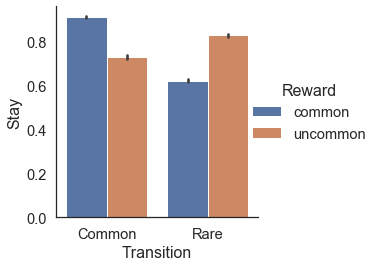

In [55]:
## Concatenate DataFrames.
dd = concat(dd)
dd.prev_R = dd.prev_R.replace({1:'rewarded',0:'unrewarded'})
dd.prev_T = dd.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=dd, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

## Method #2

In [210]:
MB = []
MF = []
for s in subjects:
    sd = data.loc[data['subject'] == s]
    g1 = sd.loc[(sd['prev_T'] == '0.0') & (sd['prev_R'] == '1.0')]
    g2 = sd.loc[(sd['prev_T'] == '1.0') & (sd['prev_R'] == '0.0')]
    
    m1 = np.array(g1['Stay'], dtype=int).mean()
    m2 = np.array(g2['Stay'], dtype=int).mean()  # larger if MF
    
    if math.isclose(m1, m2, rel_tol=0.06) and (m2 <= m1): MB.append(s)
    else: MF.append(s)

In [211]:
len(MF)

1225

In [212]:
len(MB)

184

In [220]:
percent_MB = len(MB)/len(subjects)
percent_MF = len(MF)/len(subjects)
print("Percent of model-based participants: " + str(round(percent_MB,2)))
print("Percent of model-free participants: " + str(round(percent_MF,2)))

Percent of model-based participants: 0.13
Percent of model-free participants: 0.87


# Multi-Subject Graphing

In [225]:
dd = []
for s in MF:
    mt = f.loc[f['subject'] == s]
    
    r = mt['outcome']
    Y1 = mt['stage_1_choice']
    t = mt['transition']

    y1F = np.array(Y1[1:])
    y1B = np.array(Y1[:-1])
    
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = np.where(y1B == y1F, 1, 0)
    
    g = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    dd.append(g)

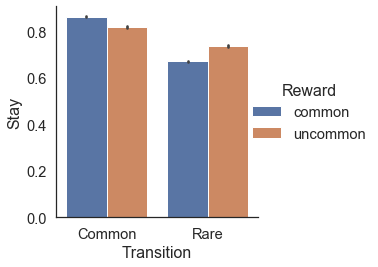

In [226]:
## Concatenate DataFrames.
dd = concat(dd)
dd.prev_R = dd.prev_R.replace({1:'rewarded',0:'unrewarded'})
dd.prev_T = dd.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=dd, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# Single-Subject Graphing

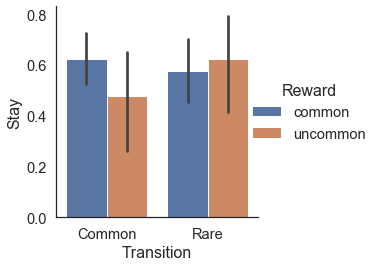

In [44]:
subdata = f.loc[f['subject'] == subjects[30]]
# decent looking ones: 30,
    
r = subdata['outcome']
Y1 = subdata['stage_1_choice']
t = subdata['transition']

y1F = np.array(Y1[1:])
y1B = np.array(Y1[:-1])
    
prev_R = np.roll(r, 1)[1:]
prev_T = np.roll(t, 1)[1:]
stay = np.where(y1B == y1F, 1, 0)
    
d = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])

d.prev_R = d.prev_R.replace({1:'rewarded',0:'unrewarded'})
d.prev_T = d.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=d, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

# Single-Subject Plotting

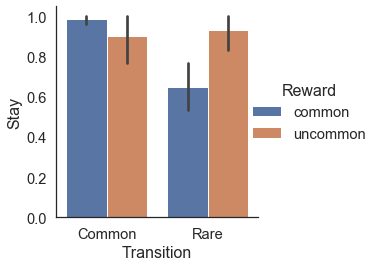

In [132]:
subdata = df.loc[df['subject'] == subs[30]]
# decent looking ones: 30,
    
r = subdata['outcome']
Y1 = subdata['stage_1_choice'] - 1
t = subdata['transition']

y1F = np.array(Y1[1:])
y1B = np.array(Y1[:-1])
    
prev_R = np.roll(r, 1)[1:]
prev_T = np.roll(t, 1)[1:]
stay = np.where(y1B == y1F, 1, 0)
    
data = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])

data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

In [133]:
data

,prev_R,prev_T,Stay
0,rewarded,uncommon,1.0
1,unrewarded,common,1.0
2,rewarded,common,1.0
3,rewarded,uncommon,1.0
4,rewarded,common,1.0
...,...,...,...
190,unrewarded,uncommon,1.0
191,unrewarded,common,0.0
192,rewarded,common,1.0
193,unrewarded,common,0.0


# Stan Testing

In [15]:
import os, pystan
import _pickle as pickle

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

# Single-Subject EA Fit

In [16]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [24]:
subdata = df.loc[df['subject'] == subs[1]]

In [25]:
subdata

,index,subject,trial,drift_1,drift_2,drift_3,drift_4,stage_1_choice,stage_1_rt,transition,stage_2_choice,stage_2_state,stage_2_rt,outcome
169,200,304SM51WA34XCM4E67SL28LY2UCBS4,1,0.743,0.273,0.717,0.479,1.0,2.196,1.0,1.0,2.0,1.179,1.0
170,201,304SM51WA34XCM4E67SL28LY2UCBS4,2,0.714,0.290,0.712,0.456,2.0,1.241,1.0,1.0,3.0,1.164,1.0
171,202,304SM51WA34XCM4E67SL28LY2UCBS4,3,0.709,0.346,0.714,0.466,2.0,0.994,1.0,1.0,3.0,0.493,1.0
172,203,304SM51WA34XCM4E67SL28LY2UCBS4,4,0.732,0.339,0.704,0.386,2.0,0.553,1.0,1.0,3.0,0.436,1.0
173,204,304SM51WA34XCM4E67SL28LY2UCBS4,5,0.717,0.408,0.722,0.422,1.0,0.530,0.0,1.0,3.0,0.772,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,395,304SM51WA34XCM4E67SL28LY2UCBS4,196,0.384,0.712,0.479,0.387,2.0,0.520,0.0,2.0,2.0,0.324,0.0
364,396,304SM51WA34XCM4E67SL28LY2UCBS4,197,0.373,0.734,0.460,0.375,2.0,1.593,1.0,2.0,3.0,1.828,1.0
365,397,304SM51WA34XCM4E67SL28LY2UCBS4,198,0.440,0.748,0.461,0.410,2.0,0.538,1.0,2.0,3.0,0.860,1.0
366,398,304SM51WA34XCM4E67SL28LY2UCBS4,199,0.471,0.737,0.468,0.375,2.0,1.138,1.0,2.0,3.0,0.845,0.0


In [36]:
r = subdata['outcome'].astype(int)
Y1 = (subdata['stage_1_choice'] - 1).astype(int)
Y2 = (subdata['stage_2_choice'] - 1).astype(int)
S2 = (subdata["stage_2_state"] - 2).astype(int)
t = subdata['transition'].astype(int)
T = len(subdata)

In [42]:
# NOTE: haven't run whole block yet!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [43]:
StanModel.optimizing(data=dd)

OrderedDict([('eta1_pr', array(-0.33598916)),
             ('eta2_pr', array(-0.36216315)),
             ('beta1_pr', array(-2.11954778)),
             ('beta2_pr', array(-2.78483893)),
             ('w_pr', array(0.5270087)),
             ('p_pr', array(0.00012109)),
             ('eta1', array(0.36831494)),
             ('eta2', array(0.3584855)),
             ('beta1', array(0.33977671)),
             ('beta2', array(0.05080411)),
             ('w', array(0.70104458)),
             ('p', array(0.50004836)),
             ('Y1_pd', array(0.4983963)),
             ('Y2_pd', array(0.49788694))])

In [44]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [45]:
print(StanFit)

Inference for Stan model: anon_model_bffbd421009e6eded8ba0311899b7864.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta1_pr   -1.17    0.03   1.38  -3.17  -2.35  -1.39  -0.12    1.6   2091    1.0
eta2_pr   -0.97    0.03   1.44   -3.7  -1.97  -0.82   0.09   1.53   2466    1.0
beta1_pr  -1.51    0.03   1.13  -3.15  -2.31  -1.82   -0.8   1.13   1768    1.0
beta2_pr  -2.51    0.02    0.9  -3.73  -3.03   -2.7  -2.29    0.1   1669    1.0
w_pr       0.44    0.02   1.02  -1.69  -0.21    0.5   1.12   2.34   4575    1.0
p_pr     2.7e-4    0.01    1.0  -1.96  -0.68 9.9e-3   0.68   1.98   5007    1.0
eta1       0.25  6.1e-3   0.31 6.6e-4 9.4e-3   0.08   0.45   0.95   2500    1.0
eta2        0.3  4.7e-3    0.3 7.6e-5   0.02   0.21   0.54   0.94   4049    1.0
beta1      3.22    0.11   4.88   0.01   0.21   0.69   4.21  17.41   1815    1.0
beta2      

# Single-Subject TDLR Fit

In [49]:
PATH_NAME = '/Users/kierstenmarr/Desktop/TDLR'

In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'TDLR.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [ ]:
StanModel.optimizing(data=dd)

In [52]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [53]:
print(StanFit)

Inference for Stan model: anon_model_7d0126e435e3cc097a74141d06c2b498.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1_pr  -1.93  7.2e-3   0.45  -2.97   -2.2  -1.87  -1.61   -1.2   3948    1.0
beta2_pr  -1.26  2.0e-3   0.14  -1.54  -1.35  -1.26  -1.17   -1.0   4638    1.0
etaC_pr   -0.17  6.1e-3   0.41  -0.93  -0.44   -0.2   0.06   0.71   4604    1.0
etaR_pr   -0.38  7.8e-3   0.56  -1.43  -0.74   -0.4  -0.07   0.85   5163    1.0
beta1      0.76  8.3e-3   0.62   0.03   0.28   0.62   1.09   2.31   5644    1.0
beta2      2.11  7.2e-3   0.49   1.24   1.76   2.08   2.42   3.17   4622    1.0
etaC       0.43  2.1e-3   0.15   0.18   0.33   0.42   0.53   0.76   4824    1.0
etaR       0.37  2.5e-3   0.18   0.08   0.23   0.34   0.47    0.8   5215    1.0
Y1_pd       0.5  7.8e-6 6.0e-4    0.5    0.5    0.5    0.5    0.5   5955    1.0
Y2_pd      

# Single-Subject Hybrid Fit

In [ ]:
PATH_NAME = '/Users/kierstenmarr/Desktop/hybrid'

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'hybrid.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

In [ ]:
StanModel.optimizing(data=dd)

In [ ]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [ ]:
print(StanFit)

# Single-Subject MB Fit

In [54]:
PATH_NAME = '/Users/kierstenmarr/Desktop/MB'

In [55]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'MB.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [56]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6c8dade991164aefed5354789d4eed NOW.


In [ ]:
StanModel.optimizing(data=dd)

In [ ]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [ ]:
print(StanFit)